# Differentiation matrices

Now we return to the example of indefinite integration we used at the beginning of the chapter,

$$
u'(x) = g(x), \quad u(a)=0, \quad a < x < b. 
$$

If we discretize the domain $[a,b]$ by the nodes

$$
x_i = a + ih, \quad h = \frac{b-a}{n}, \quad i=0,\ldots,n,
$$

then we were able to summarize imposing the ODE at the nodes through a linear system starting with the differentiation matrix

$$
\bfD_x = 
\frac{1}{2h}
\begin{bmatrix} 
-2 & 2 & & & \\ 
-1 & 0 & 1 & & \\ 
& \ddots & \ddots & \ddots  & \\ 
& & -1 & 0 & 1 \\ 
& & & -2 & 2 
\end{bmatrix}.
$$

We can likewise build a differentiation matrix for the second derivative,

$$
\bfD_{xx} = \frac{1}{h^2}  \begin{bmatrix} 
1 & -2 & 1 & & & \\ 
1 & -2 & 1 & & & \\ 
0 & 1 & -2 & 1 & & \\ 
& & \ddots & \ddots & \ddots & \\ 
& & & 1 & -2 & 1 \\
& & & 1 & -2 & 1 
\end{bmatrix}
$$

In [1]:
using LinearAlgebra
function diffmats(x)
    # assumes evenly spaced nodes
    h = x[2]-x[1]
    m = length(x)
    Dx = 1/2h*diagm(-1=>[-ones(m-2);-2],0=>[-2;zeros(m-2);2],1=>[2;ones(m-2)])
    Dxx = 1/h^2*diagm(-1=>[ones(m-2);-2],0=>[1;-2*ones(m-2);1],1=>[-2;ones(m-2)])
    Dxx[m,m-2] = Dxx[1,3] = 1/h^2
    return Dx,Dxx
end

diffmats (generic function with 1 method)

It's unfortunate that the first and last rows in each differentiation matrix are first-order accurate, while the others are all second-order. More about that in a moment. 

## Double integration

The problem

$$
u''(x) = f(x)
$$

is solved by integrating twice. The two integration constants have to be specified by initial or boundary conditions. We'll suppose that $u(0)=1$ and $u(1)=-1$. 

The discrete collocation system is $\bfD_{xx} \bfu = \bff$, where $\bff$ represents the evaluation of $f(x)$ on the nodes. We could proceed as we did before and modify the first and last rows of the system to express the boundary conditions, but we will take a different path here. If we put in the boundary values in place of $u_0$ and $u_n$, we have

$$
\bfD_{xx} 
\begin{bmatrix}
  1 \\ u_1 \\ u_2 \\ \vdots \\ u_{n-1} \\ -1
\end{bmatrix}
= [ f(x_i) ]_{i=0,\ldots,n}.  
$$

Let $\bfd_0,\ldots,\bfd_n$ be the columns of $\bfD_{xx}$. Then 

$$
1 \bfd_0 - 1 \bfd_n + 
\begin{bmatrix}
  \bfd_1 & \cdots & \bfd_{n-1}
\end{bmatrix}
\begin{bmatrix}
  u_1 \\ u_2 \\ \vdots \\ u_{n-1}
\end{bmatrix}
= \bff. 
$$

Define the *chopping matrix* $\bfC$ as an $(n+1)$-identity matrix with its first and last columns removed. Then we have

$$
(\bfD_{xx}\bfC) (\bfC^T \bfu) = \bff - \bfd_0 + \bfd_n. 
$$

This system has $n+1$ rows but only $n-1$ unknowns remaining, so we will chop off the first and last rows as well. Define 

$$
\bfA = \bfC^T \bfD_{xx} \bfC, \quad \tilde{\bfu} = \bfC^T \bfu.
$$

The reduced linear system is now 

$$
\bfA \tilde{\bfu} = \bfC^T (\bff - \bfd_0 + \bfd_n). 
$$

In practice we can simply use row and column indexing rather than constructing the matrix $\bfC$.

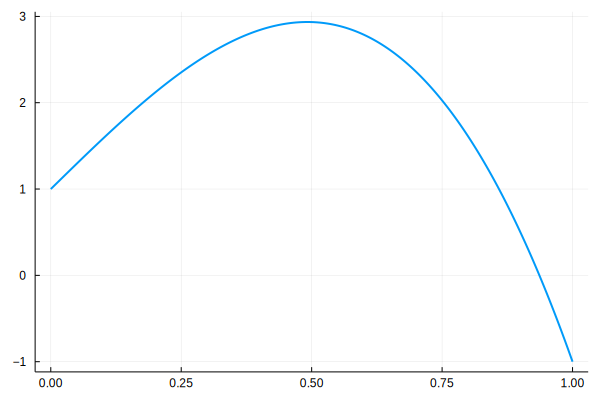

In [2]:
a,b = 0,1
f(x) = -50sin(x)
n = 200
h = (b-a)/n
x = [a + i*h for i in 0:n]
_,Dxx = diffmats(x)
A = Dxx[2:n,2:n]
rhs = (f.(x) - Dxx[:,1] + Dxx[:,n+1])[2:n]
ũ = A\rhs
u = [1;ũ;-1]

using Plots
plot(x,u)

In [3]:
norm(Dxx*u-f.(x))/norm(u)

0.009251046829423357

## Convergence

Some experimentation will confirm that the code above converges like $O(h^2)$. While this seems to be a natural result of using second-order FD formulas, it's not quite so simple---the formulas get the *problem* correct to 2nd order, but that doesn't prove that the *solution* is as accurate. We will investigate the link between them in the next chapter.

It is surprising, however, that our earlier code to solve $u'=f$ also converged at second order, given that it used the first-order backward difference formula at the right endpoint. While the rigorous details are messy, in essence the saving grace of the method is that the less-accurate formula is used at only $O(1)$ of the $O(1/h)$ total equations, and this buys back one extra order of accuracy in the result. This is usually the case: the order of accuracy of the FD formula can be one lower at a fixed number of nodes as $h\to 0$ without damaging the convergence.